# RQ 2 (Size)

> What is the size of unsafe blocks that programmers write?

## Setup

In [30]:
# import libraries
import itertools
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

import utils
import top_crates
from whitelists import *
from drawing import *

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15/1.5, 8/1.4]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)
# Font for paper
plt.rc('font', family='serif')

In [31]:
# Load tables
unsafe_blocks = utils.load_unsafe_thir_blocks()
unsafe_block_sizes = utils.load_unsafe_thir_block_sizes()

# Preprocessing
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"].copy()


## Query 3

> how many MIR statements does the compiler generate for user-written unsafe blocks

#### Results from the paper for comparison (Fig. 3)

![Fig. 3](pics/unsafe_blocks_size_cumulative.png)

In [32]:
# Count MIR elements
sizes_df = user_written_unsafe_blocks[['block']].join(
    unsafe_block_sizes[['block', 'statement_count']].set_index('block'),
    on='block',
    how='left',
)
user_written_unsafe_blocks["statements_count"] = sizes_df.statement_count
# fill NA with 0
user_written_unsafe_blocks["statements_count"] = user_written_unsafe_blocks["statements_count"].fillna(0)
user_written_unsafe_blocks[["block", "statements_count"]]

,block,statements_count
0,13,2.0
1,22,0.0
2,52,0.0
3,44,0.0
4,68,0.0
5,59,0.0
6,65,0.0
7,71,0.0
8,88,0.0
9,92,0.0


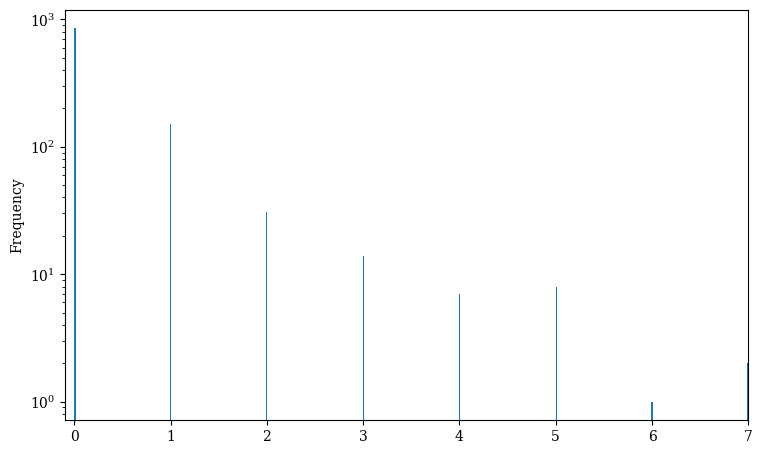

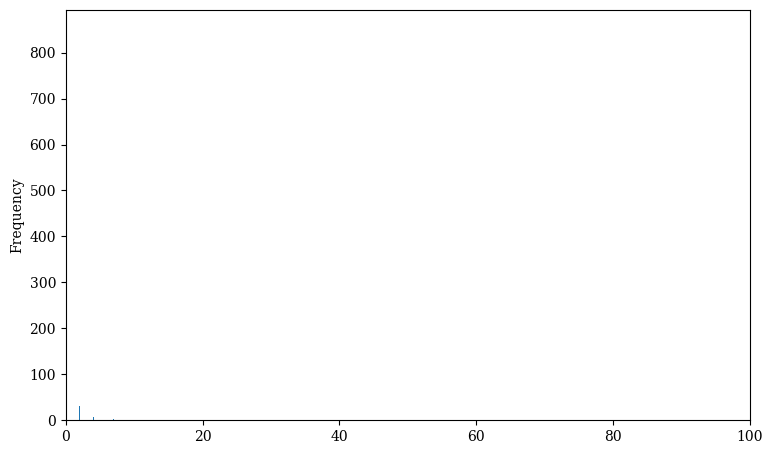

/tmp/ipykernel_3654/2447950371.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


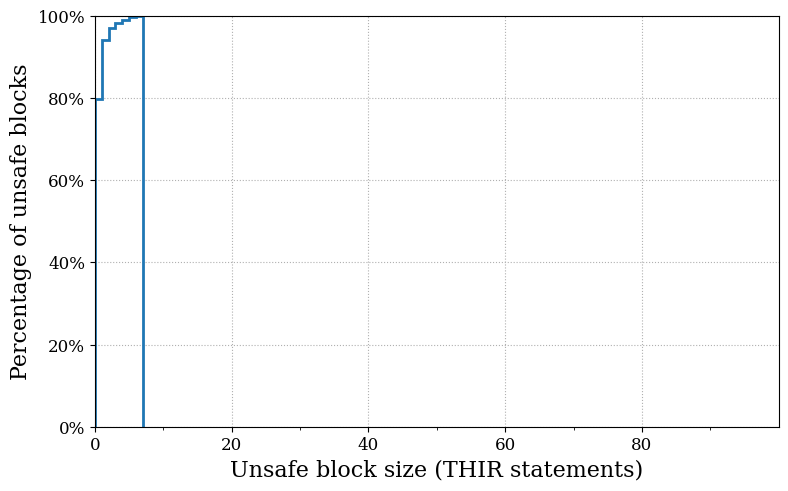

The portion of unsafe blocks covered in the depicted graph: 100.0 %
The portion of unsafe blocks with #21 thir statements or less: 100.0 %
Mean size of a unsafe block: 0.3220657276995305
Median size of a unsafe block: 0.0


In [33]:
# Plot histograms

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15/1.7, 8/1.5]

user_written_unsafe_blocks.statements_count.plot.hist(
    bins=500,
    log=True,
    xlim=(-0.1, user_written_unsafe_blocks.statements_count.max())
)
plt.show()

user_written_unsafe_blocks.statements_count.describe()

user_written_unsafe_blocks[
    user_written_unsafe_blocks.statements_count <= 100
].statements_count.plot.hist(
    bins=100,
    xlim=(0, 100)
)
plt.show()

ax = user_written_unsafe_blocks.statements_count.plot.hist(
    cumulative=True,
    density=1,
    bins=int(user_written_unsafe_blocks.statements_count.max()),
    xlim=(0, 100),
    ylim=(0, 1),
    histtype="step",
    linewidth=2,
    fontsize=12,
    # title="Cumulative distribution",
)
ax.title.set_size(20)
ax.set_xlabel("Unsafe block size (THIR statements)", fontsize=16)
ax.set_ylabel("Percentage of unsafe blocks", fontsize=16)
ax.set_axisbelow(True)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_xticks(range(0, 100, 10), minor=True)
ax.set_xticks(range(0, 100, 20))
ax.grid(True, linestyle='dotted')
plt.show()
print("The portion of unsafe blocks covered in the depicted graph:",
    100 * len(user_written_unsafe_blocks.query("statements_count <= 100"))
    /len(user_written_unsafe_blocks), "%"
)
print("The portion of unsafe blocks with #21 thir statements or less:",
    100 * len(user_written_unsafe_blocks.query("statements_count <= 21"))
    /len(user_written_unsafe_blocks), "%"
)
print("Mean size of a unsafe block:", user_written_unsafe_blocks.statements_count.mean())
print("Median size of a unsafe block:", user_written_unsafe_blocks.statements_count.median())

## Follow-ups

> there is a significant share, namely 14.4% of tiny unsafe blocks that either wrap an expression (without function calls) or call a single unsafe function without changing any of its arguments

In [34]:
print("Not supported right now.")
assert False

print("{:.1%} of the user-written unsafe blocks just call an unsafe functions, whithout evaluationg expressions for the arguments".format(
    sum(user_written_unsafe_blocks.mir_statements_count == 0) / len(user_written_unsafe_blocks)
))
print("{:.1%} of the user-written unsafe blocks just evaluates an expression, whithout calling any function".format(
    sum(user_written_unsafe_blocks.mir_terminators_count == 0) / len(user_written_unsafe_blocks)
))
print("sum: {:.1%}".format(
    (sum(user_written_unsafe_blocks.mir_statements_count == 0) +
     sum(user_written_unsafe_blocks.mir_terminators_count == 0)) /
    len(user_written_unsafe_blocks)
))

Not supported right now.


AssertionError: 

> Conversely, there is a small number (78 or 0.02%) of huge outliers whose size ranges from 2000 to 21306 #MIR.

Note: 0.02% of unsafe blocks corresponds to 78 of which
- 28 are generated by macros, 
- 16 are generated at compile time, and
- 34 appear to be user written.

In [35]:
large_blocks = user_written_unsafe_blocks.query("statements_count >= 2000")
print("Count of huge outliers:", len(large_blocks))
print("Percentage:", 100*len(large_blocks)/len(user_written_unsafe_blocks))
print("Largest:", user_written_unsafe_blocks.statements_count.max())

Count of huge outliers: 0
Percentage: 0.0
Largest: 7.0


In [37]:
data = user_written_unsafe_blocks[
    (user_written_unsafe_blocks.statements_count >= 2000)
    & (user_written_unsafe_blocks.expansion_kind != "Root")
]
print("gen by macros:", len(data))
print(data.crate.value_counts())
del data

gen by macros: 0
Series([], Name: count, dtype: int64)


In [38]:
data = user_written_unsafe_blocks[
    (user_written_unsafe_blocks.statements_count >= 2000)
    & (user_written_unsafe_blocks.expansion_kind == "Root")
    & (user_written_unsafe_blocks.file_name.str.contains("out/"))
]
print("gen at compile time:", len(data))
print(data.crate.value_counts())
del data

gen at compile time: 0
Series([], Name: count, dtype: int64)


In [39]:
data = user_written_unsafe_blocks[
    (user_written_unsafe_blocks.statements_count >= 2000)
    & (user_written_unsafe_blocks.expansion_kind == "Root")
    & (~user_written_unsafe_blocks.file_name.str.contains("out/"))
]
print("not gen at compile time or by macros:", len(data))
print(data.crate.value_counts())
print("top cases:")
data[
    data.statements_count >= 12000
]

not gen at compile time or by macros: 0
Series([], Name: count, dtype: int64)
top cases:


,build,crate,crate_hash,def_path,def_path_hash,summary_key,block,check_mode,span,expansion_kind,expansion_kind_descr,file_name,line,col,statements_count
